In [4]:
import numpy as np
import pandas as pd
import os
import itertools
import glob
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [3]:
#from PreprocessingLabeledData import *
#from AddingPredProbAndLabel2DF import *
#from OverLapReturner import OverLapReturner
#from SelectingBestNonOverlappingHits import *

In [6]:
from numpy import log

def PreprocessingLabeledData(df):
    """This is for calculating the pfam coverage, and replacing 0 e-values, it will also change
    the order of the columns. Before running this, the input must have been labeled. """
    df["FracOfPf"] = (df["qend"] -df["qstart"] + 1)/df["qlen"]
    df["p_evalue"] = -log(df["evalue"] + 1e-300)
    df["MismatchRatio"] = df["mismatch"]/df['alnlen'] *100
    df["GapOpenRatio"] = df["gapopen"]/df['alnlen'] *100
    ColumnNames = ['fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'qlen', 'bits', "FracOfPf","p_evalue", 'query', 'target','qstart',
       'qend', 'tstart', 'tend', 'tlen','PredPF', 'PF', 'PFstart', 'PFend', 'evalue', 'Status']
    df = df[ColumnNames]
    return df

In [30]:
def AddingPredProbAndLabel2DF(X, model):
    """This is for adding the predictions and the confidence score to each alignment record"""
    PredProb  = model.predict_proba(X[:,:7])[:, 1]
    PredLabel = model.predict(X[:,:7])
    df = pd.DataFrame(data = X, columns = ['fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'qlen', 'bits', "FracOfPf","p_evalue", 'query', 'target','qstart',
       'qend', 'tstart', 'tend', 'tlen','PredPF', 'PF', 'PFstart', 'PFend', 'evalue', 'Status'])
    df["PredLabel"] = PredLabel
    df["RF_prob"] = PredProb
    df = df[df["PredLabel"]==1]
    df.sort_values(by=["target", "RF_prob"], ascending=[True, False], ignore_index = True, inplace=True)
    dfNewOrder = df[['target','PredPF','tstart', 'tend',"RF_prob", "PredLabel",  
        'fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'qlen', 'bits',
        "FracOfPf","p_evalue", 'PF', 'PFstart', 'PFend', 'evalue', 'Status']]
    return df

In [8]:
def OverLapReturner(Interval1, Interval2):
    """It takes two intervals as input and returns the overlap between them as output"""
    MaxStart = max(Interval1[0], Interval2[0])
    MinEnd  =  min(Interval1[1], Interval2[1])
    return max(MinEnd-MaxStart+1,0)

In [9]:
def SelectingBestNonOverlappingHits(df,PF_Anns = {}):
    """This function takes the dataframe containing all preprocessed alignments as input, and reports 
    the highest scoring non-overlapping alignments on each target protein. Optionally, you can specify 
    the current Pfam annotations of the proteins in a dictionary whose keys are gene names, and values
    are tuples of the intervals of the pfams"""
    ListOfRows = []
    OverlapThreshold = 10
    for (i, CurID,start, end)  in zip(df.index, df["target"], df['tstart'],df['tend']):
        row = df.loc[i,:]
        ListOfIntervals = PF_Anns.get(CurID, [])
        SignificantOverLap = False
        for Interval in ListOfIntervals:
            if OverLapReturner(Interval, (start,end)) >= OverlapThreshold:
                SignificantOverLap = True
                break
        if (SignificantOverLap==False):
            ListOfRows.append(row)
            ListOfIntervals.append((start,end))
            PF_Anns[CurID] = ListOfIntervals
    OutDF = pd.DataFrame(data= ListOfRows, columns = df.columns)
    return OutDF

In [10]:
%matplotlib inline

In [11]:
LabeledDataAddressDict = {}
LabeledDataAdds = sorted(glob.glob("../intermediates//*_seq_labeled.tsv"))
DictOfAdds = {os.path.normpath(x).split(os.sep)[2]:x for x in LabeledDataAdds}
#FullNameDict = {"Sc": "S. cerevisiae", "Ec":"E. coli","Mj":"M. jannaschii", "Tb":"T. brucei"}

In [12]:
AddressTbData = DictOfAdds["Tb"]
TbData = pd.read_csv(AddressTbData, sep="\t")
TbData = PreprocessingLabeledData(TbData)
LabeledData_tb = TbData[TbData["Status"]!=-1]
LabeledData_tb = LabeledData_tb.sample(frac=1, random_state=1).reset_index(drop=True)

X_tb = LabeledData_tb.values
y_tb = LabeledData_tb['Status'].values

In [13]:
totalNumAli = TbData.shape[0]
print("There are a total of {} possible alignments between Proteome of interest and Pfam instances".format(totalNumAli))
print("{} percent of the data is labeled as 1 ".format(LabeledData_tb[LabeledData_tb["Status"]==1].shape[0]*100/totalNumAli))
print("{} percent of the data is labeled as 0 ".format(LabeledData_tb[LabeledData_tb["Status"]==0].shape[0]*100/totalNumAli))

There are a total of 254423 possible alignments between Proteome of interest and Pfam instances
91.78690605802149 percent of the data is labeled as 1 
7.122390664366036 percent of the data is labeled as 0 


In [14]:
TbData.columns

Index(['fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'qlen', 'bits',
       'FracOfPf', 'p_evalue', 'query', 'target', 'qstart', 'qend', 'tstart',
       'tend', 'tlen', 'PredPF', 'PF', 'PFstart', 'PFend', 'evalue', 'Status'],
      dtype='object')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_tb, y_tb, train_size = 0.9, test_size=0.1, shuffle=False)
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, train_size = 0.5, test_size=0.5, shuffle=False)

In [16]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
rf.fit(X_train[:,:7], y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [43]:
ModelDict = {}
TrainSizes = [0.01] #Add whatever fraction you want to test to this dictionary
ModelDict[1] = rf
for train_size in TrainSizes:
    X_train_frac, X_test_frac, y_train_frac, y_test_frac = train_test_split(X_train,y_train, train_size = train_size, test_size=1- train_size, shuffle=False)
    rf = RandomForestClassifier(n_estimators=100, criterion='gini', n_jobs=-1)
    rf.fit(X_train_frac[:,:7], y_train_frac)
    ModelDict[train_size] = rf

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

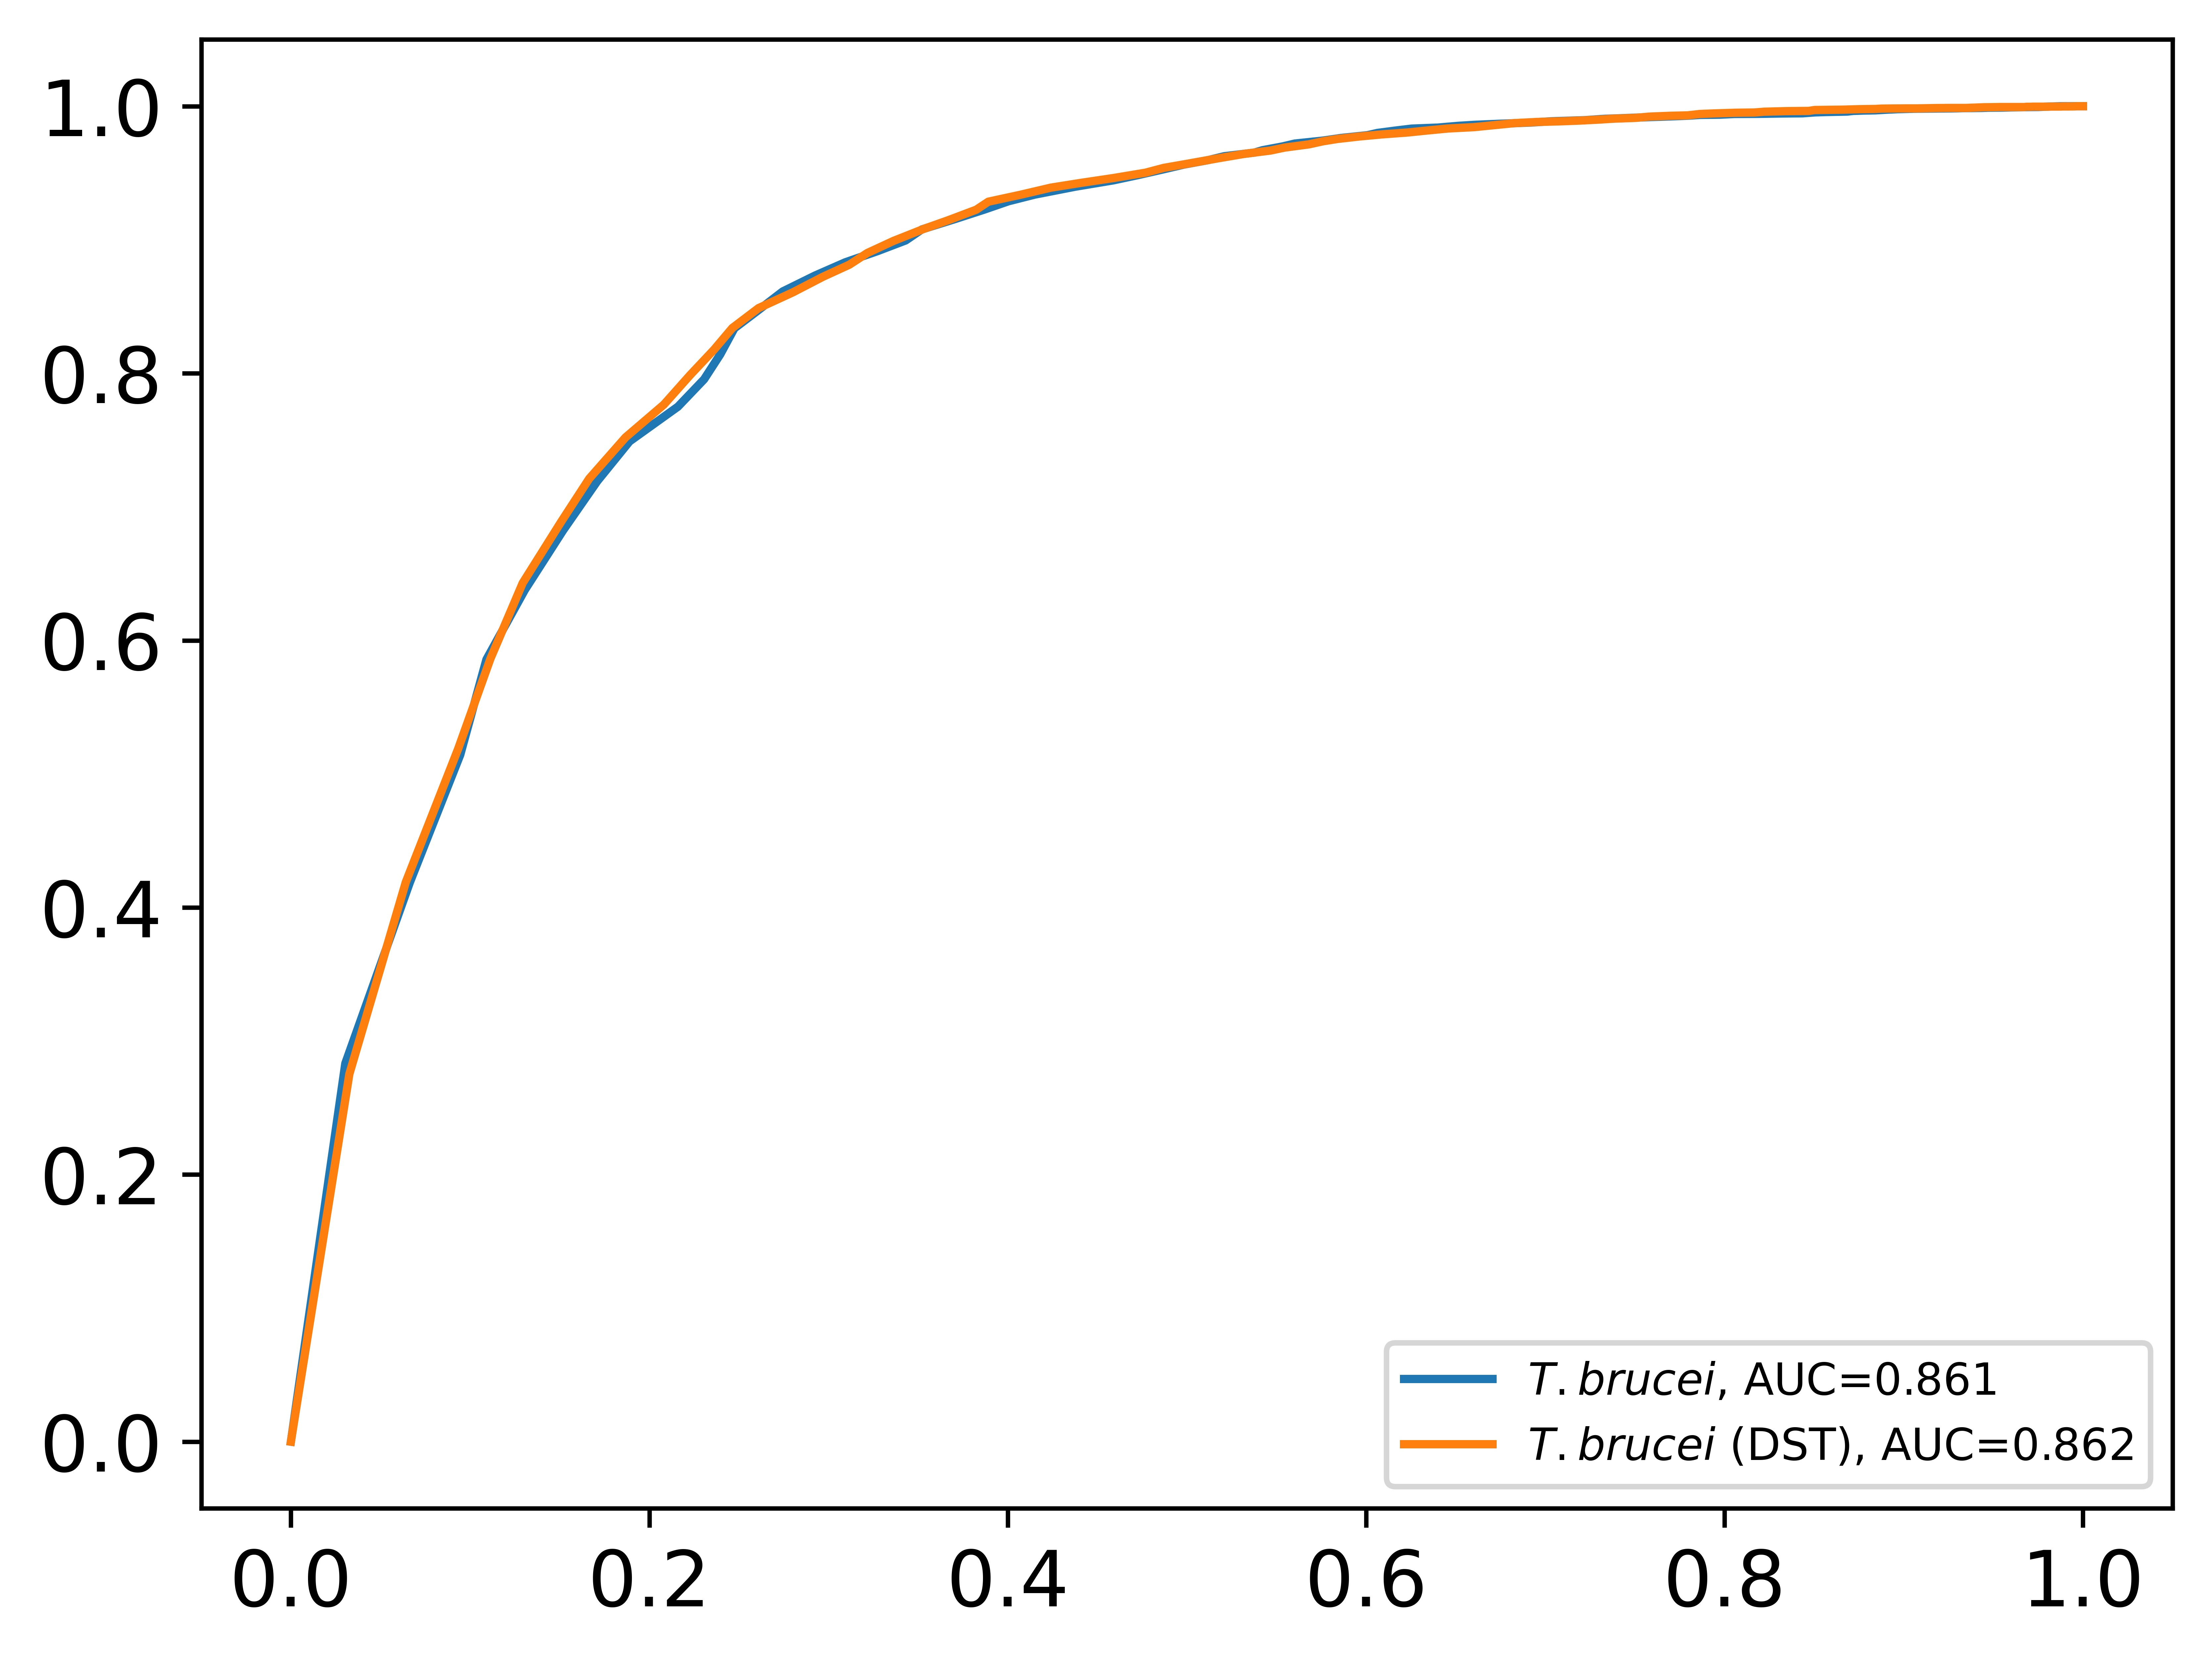

In [44]:
plt.figure(0).clf()
plt.figure(dpi=1200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#add legend
plt.legend()

for frac in ModelDict.keys():
    model = ModelDict[frac]
    y_pred_prob = model.predict_proba(X_test[:,:7])[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    auc = round(metrics.roc_auc_score(y_test, y_pred_prob),3)
    if frac!= 1:
        plt.plot(fpr,tpr,label= "$\it{T. brucei}$ (DST)" +", AUC="+str(auc))
    else:
        plt.plot(fpr,tpr,label= "$\it{T. brucei}$" + ", AUC="+str(auc))
   
model = ModelDict[1]

plt.legend( prop={'size': 8})

# Best hit attribution benchmarking
The next part is for Evaluating Best Hit attribution, first, we have to predict the probability and the label of each alignment by the trained model, then select the best hit, and continue annotating new domain to the point each newly added domain overlaps less than 10 aminoacids with previously added domains.

In [20]:
def Precision(df):
    TotalPreds = df.shape[0]
    CorrectPreds = df[df["Status"]==1].shape[0]
    return CorrectPreds/TotalPreds

In [31]:
model = ModelDict[1]
PrecisionDict = {}
AnnotDict = {}
AnnotDFTb = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_tb, model))
AnnotDict["Tb"] = AnnotDFTb


In [32]:
for org in AnnotDict.keys():
    annots = AnnotDict[org]
    TruePreds = annots[annots["Status"]==1] 
    print("{} percent of Annotated Pfams have been correctly annotated for {}".format(100* Precision(annots), org))
    

94.4767987976705 percent of Annotated Pfams have been correctly annotated for Tb


In [38]:
AnnotDFTb.shape[0]/6684

0.7963794135248354

In [33]:
AnnotDict.keys()

dict_keys(['Tb'])

In [35]:
model.feature_importances_

array([0.13481243, 0.16441633, 0.12225507, 0.12920924, 0.19143153,
       0.12026448, 0.13761091])

In [45]:
model = ModelDict[1]
FeatureImps = model.feature_importances_
FeatureNames = ['fident', 'alnlen', 'nmismatch', 'ngapopen', 'pflen', 'bit score',  "pfcov"]
SortedFeatures = sorted(zip(FeatureNames, FeatureImps), key=lambda x: x[1], reverse=True)
for item in SortedFeatures:
    print(item[0] + "\t"+ str(item[1]))

pflen	0.19143153432747664
alnlen	0.16441633417960497
pfcov	0.13761091384015334
fident	0.13481242676184874
ngapopen	0.12920924471585382
nmismatch	0.12225506753583203
bit score	0.12026447863923063


# Annotating New Genes in T. brucei

In [39]:
PfamAnnDict = {}
PfamsTb = open("../rawinput/Tb/PfamTb.txt")
for line in PfamsTb:
    Gene, Pf, start,end = line.strip().split()
    Intervals = PfamAnnDict.get(Gene, [])
    Intervals.append((int(start), int(end)))
    PfamAnnDict[Gene] = Intervals

In [40]:
X_to_check_Tb = TbData[TbData["Status"]==-1].values

In [41]:
model = ModelDict[1]
NewlyAnn = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_to_check_Tb, model), PfamAnnDict)

In [42]:
NewlyAnn.shape

(872, 23)

In [29]:
NewlyAnn.columns
NewlyAnn = NewlyAnn[['target', 'PredPF', 'tstart', 'tend', 'RF_prob','query', 'fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'qlen', 'bits',
       'FracOfPf', 'p_evalue',  'qstart',
       'qend', 'tlen', 'PF', 'PFstart', 'PFend',
       'evalue', 'Status', 'PredLabel']]
NewlyAnn = NewlyAnn[['target', 'PredPF', 'tstart', 'tend', 'RF_prob','query', 'fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'qlen', 'bits',
       'alntmscore', 'FracOfPf', 'p_evalue',  'qstart',
       'qend', 'tlen']]

In [30]:
NewlyAnn.columns = ['Query', 'PredPF', 'Qstart', 'Qend', 'RF_prob','PFinstance', 'fident', 'alnlen', 'nmismatch', 'ngapopen', 'PFlen', 'bit score',
       'pfcov', 'p_evalue',  'InstanceStart',
       'InstanceEnd', 'Qlen']

In [31]:
NewlyAnn.to_csv("../predictions/NewPredictionsTb.txt", index=None, sep="\t")

In [32]:
NewlyAnn.groupby(['PredPF'])['PredPF'].count().sort_values(ascending=False)[:10]

PredPF
PF13458    72
PF12799    50
PF00400    41
PF00913    31
PF00560    30
PF00076    29
PF12894    20
PF01762    19
PF14783    19
PF00225    16
Name: PredPF, dtype: int64